# VIF Critic TCN Training Notebook

This notebook trains and evaluates a **Temporal Convolutional Network (TCN)** critic using a **short text window** (e.g. current + 2 previous entries).

**What is this model?**
- A TCN backbone over the text embedding window (shape: \(L=\) `window_size`, \(C_{in}=\) `embedding_dim`)
- Concatenates the TCN representation with the non-text features already in the state vector (time gaps + EMA history + profile)
- Predicts 10-dim Schwartz alignment scores in `[-1, 1]`
- Optional: **Bayesian head** using `bayesian-torch` for principled uncertainty

**Contents:**
1. Data Loading & Exploration
2. Encoder + State Vector
3. TCN Model (optional Bayesian head)
4. Training Loop
5. Evaluation & Visualization


In [1]:
# Setup
import os
import sys
from pathlib import Path

# Change to project root so relative paths work correctly
# (notebook runs from notebooks/, data lives at project root)
notebook_dir = Path.cwd()
if notebook_dir.name == "notebooks":
    os.chdir(notebook_dir.parent)
sys.path.insert(0, ".")

import numpy as np
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
import polars as pl
import matplotlib.pyplot as plt

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Device selection: CUDA > MPS (Apple Silicon) > CPU
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Working directory: {os.getcwd()}")
print(f"Using device: {device}")


Working directory: /Users/leongkaymei/Desktop/NUS-ISS/Capstone/twinkl
Using device: mps


## 1. Data Loading & Exploration

In [2]:
# Load raw data to explore
from src.vif.dataset import load_all_data, split_by_persona, merge_labels_and_entries

labels_df, entries_df = load_all_data()

print(f"Labels: {labels_df.shape}")
print(f"Entries: {entries_df.shape}")
print(f"Unique personas: {labels_df.select('persona_id').n_unique()}")


Labels: (740, 15)
Entries: (722, 8)
Unique personas: 102


In [3]:
# Examine label distribution
from src.models.judge import SCHWARTZ_VALUE_ORDER

merged_df = merge_labels_and_entries(labels_df, entries_df)

print("Alignment value distribution per dimension:")
print("=" * 50)
for dim in SCHWARTZ_VALUE_ORDER:
    col = f"alignment_{dim}"
    series = merged_df.select(col).to_series()
    counts = {v: (series == v).sum() for v in [-1, 0, 1]}
    print(f"{dim:15s}: -1={counts[-1]:3d}, 0={counts[0]:3d}, +1={counts[1]:3d}")


Alignment value distribution per dimension:
self_direction : -1=119, 0=328, +1=275
stimulation    : -1= 44, 0=582, +1= 96
hedonism       : -1= 89, 0=521, +1=112
achievement    : -1= 58, 0=453, +1=211
power          : -1= 65, 0=588, +1= 69
security       : -1=103, 0=487, +1=132
conformity     : -1= 96, 0=470, +1=156
tradition      : -1= 50, 0=520, +1=152
benevolence    : -1= 83, 0=350, +1=289
universalism   : -1=  5, 0=644, +1= 73


In [4]:
# Split data by persona
train_df, val_df, test_df = split_by_persona(labels_df, entries_df, seed=42)

print(
    f"Train: {len(train_df)} entries ({train_df.select('persona_id').n_unique()} personas)"
)
print(
    f"Val:   {len(val_df)} entries ({val_df.select('persona_id').n_unique()} personas)"
)
print(
    f"Test:  {len(test_df)} entries ({test_df.select('persona_id').n_unique()} personas)"
)


Train: 502 entries (69 personas)
Val:   98 entries (15 personas)
Test:  122 entries (16 personas)


## 2. Encoder + State Vector

In [5]:
# Create encoder and state encoder
from src.vif.encoders import SBERTEncoder
from src.vif.state_encoder import StateEncoder

# Short window is key for this notebook
window_size = 3
ema_alpha = 0.3

# Use MiniLM for fast iteration (swap to mpnet for better quality)
text_encoder = SBERTEncoder("all-MiniLM-L6-v2")
print(f"Encoder: {text_encoder.model_name}")
print(f"Embedding dim: {text_encoder.embedding_dim}")

state_encoder = StateEncoder(text_encoder, window_size=window_size, ema_alpha=ema_alpha)
print(f"State dim: {state_encoder.state_dim}")


/Users/leongkaymei/Desktop/NUS-ISS/Capstone/twinkl/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Encoder: all-MiniLM-L6-v2
Embedding dim: 384
State dim: 1174


## 3. TCN Model (optional Bayesian head)

In [6]:
# Model hyperparameters
USE_BAYESIAN_HEAD = True  # set False for deterministic head + MC Dropout

# TCN backbone params
tcn_num_channels = [64, 64, 64]
tcn_kernel_size = 3
tcn_dropout = 0.1
tcn_causal = True
tcn_use_norm = "weight_norm"  # weight_norm | batch_norm | layer_norm
tcn_activation = "relu"
tcn_use_skip_connections = False

# Optional: custom dilations (set to None to use default exponential)
tcn_dilations = None  # e.g. [1, 2, 4]

# Head params (after TCN + non-text concat)
head_hidden_dim = 128
head_dropout = 0.2

# Bayesian head params (if enabled)
bnn_prior_mean = 0.0
bnn_prior_variance = 1.0
bnn_posterior_rho_init = -3.0

# Training / eval params
n_mc_samples = 50  # for uncertainty estimation at eval time

checkpoint_path = (
    "models/vif/notebook_tcn_bayes_best.pt" if USE_BAYESIAN_HEAD else "models/vif/notebook_tcn_best.pt"
)
print("Checkpoint:", checkpoint_path)


Checkpoint: models/vif/notebook_tcn_bayes_best.pt


In [7]:
import torch
import torch.nn as nn

from pytorch_tcn.tcn import TCN

# bayesian-torch is optional; only needed when USE_BAYESIAN_HEAD=True
if USE_BAYESIAN_HEAD:
    from bayesian_torch.layers import LinearReparameterization
    from bayesian_torch.models.dnn_to_bnn import get_kl_loss


class CriticTCN(nn.Module):
    """TCN critic over the short embedding window.

    Input: state vector shaped like StateEncoder output.
    - First window_size * embedding_dim entries correspond to text embeddings
      [current, prev1, prev2] flattened.
    - Remaining entries: time_gaps (window_size - 1), history (10), profile (10).

    We reshape text embeddings to (N, C_in=embedding_dim, L=window_size) and run a TCN.
    We take the last time step representation (causal) and concatenate non-text features.

    Output: 10-dim alignment predictions in [-1, 1].

    Optional Bayesian head: last linear layer is Bayesian (variational) and training
    adds KL loss.
    """

    def __init__(
        self,
        *,
        window_size: int,
        embedding_dim: int,
        num_values: int = 10,
        tcn_num_channels: list[int] = [64, 64, 64],
        tcn_kernel_size: int = 3,
        tcn_dilations=None,
        tcn_dropout: float = 0.1,
        tcn_causal: bool = True,
        tcn_use_norm: str = "weight_norm",
        tcn_activation: str = "relu",
        tcn_use_skip_connections: bool = False,
        head_hidden_dim: int = 128,
        head_dropout: float = 0.2,
        use_bayesian_head: bool = False,
        bnn_prior_mean: float = 0.0,
        bnn_prior_variance: float = 1.0,
        bnn_posterior_rho_init: float = -3.0,
        output_dim: int = 10,
    ):
        super().__init__()

        self.window_size = window_size
        self.embedding_dim = embedding_dim
        self.num_values = num_values
        self.output_dim = output_dim
        self.use_bayesian_head = use_bayesian_head

        # Non-text dims in StateEncoder:
        # time_gaps: window_size - 1
        # history: num_values
        # profile: num_values
        self.nontext_dim = (window_size - 1) + num_values + num_values

        self.tcn = TCN(
            num_inputs=embedding_dim,
            num_channels=tcn_num_channels,
            kernel_size=tcn_kernel_size,
            dilations=tcn_dilations,
            dropout=tcn_dropout,
            causal=tcn_causal,
            use_norm=tcn_use_norm,
            activation=tcn_activation,
            use_skip_connections=tcn_use_skip_connections,
            input_shape="NCL",
        )

        tcn_out_dim = tcn_num_channels[-1]
        head_in_dim = tcn_out_dim + self.nontext_dim

        self.head = nn.Sequential(
            nn.Linear(head_in_dim, head_hidden_dim),
            nn.LayerNorm(head_hidden_dim),
            nn.GELU(),
            nn.Dropout(head_dropout),
        )

        if self.use_bayesian_head:
            self.out = LinearReparameterization(
                head_hidden_dim,
                output_dim,
                prior_mean=bnn_prior_mean,
                prior_variance=bnn_prior_variance,
                posterior_mu_init=0.0,
                posterior_rho_init=bnn_posterior_rho_init,
                bias=True,
            )
        else:
            self.out = nn.Linear(head_hidden_dim, output_dim)

        self.tanh = nn.Tanh()

    def _split_state(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        # x: (N, state_dim)
        text_flat_dim = self.window_size * self.embedding_dim
        text_flat = x[:, :text_flat_dim]
        nontext = x[:, text_flat_dim : text_flat_dim + self.nontext_dim]
        return text_flat, nontext

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        text_flat, nontext = self._split_state(x)

        # Reshape text embeddings: (N, window_size, embedding_dim) -> (N, embedding_dim, window_size)
        text_seq = text_flat.view(-1, self.window_size, self.embedding_dim).permute(0, 2, 1)

        # TCN output: (N, C_out, L)
        tcn_out = self.tcn(text_seq)

        # Use last time step representation (causal)
        h = tcn_out[:, :, -1]

        # Concatenate non-text features
        features = torch.cat([h, nontext], dim=1)

        h2 = self.head(features)

        if self.use_bayesian_head:
            y, _ = self.out(h2)
        else:
            y = self.out(h2)

        return self.tanh(y)

    def enable_dropout(self):
        """Enable dropout modules for MC Dropout inference."""
        for module in self.modules():
            if isinstance(module, nn.Dropout):
                module.train()

    def predict_with_uncertainty(self, x: torch.Tensor, n_samples: int = 50):
        """MC sampling for uncertainty.

        - If use_bayesian_head=True: uncertainty comes from Bayesian head sampling.
        - Else: MC Dropout is used (dropout forced on).
        """
        if not self.use_bayesian_head:
            self.enable_dropout()

        samples = []
        with torch.no_grad():
            for _ in range(n_samples):
                samples.append(self.forward(x))

        samples = torch.stack(samples, dim=0)
        return samples.mean(dim=0), samples.std(dim=0)


In [8]:
# Instantiate model
model = CriticTCN(
    window_size=window_size,
    embedding_dim=text_encoder.embedding_dim,
    tcn_num_channels=tcn_num_channels,
    tcn_kernel_size=tcn_kernel_size,
    tcn_dilations=tcn_dilations,
    tcn_dropout=tcn_dropout,
    tcn_causal=tcn_causal,
    tcn_use_norm=tcn_use_norm,
    tcn_activation=tcn_activation,
    tcn_use_skip_connections=tcn_use_skip_connections,
    head_hidden_dim=head_hidden_dim,
    head_dropout=head_dropout,
    use_bayesian_head=USE_BAYESIAN_HEAD,
    bnn_prior_mean=bnn_prior_mean,
    bnn_prior_variance=bnn_prior_variance,
    bnn_posterior_rho_init=bnn_posterior_rho_init,
)
model.to(device)

n_params = sum(p.numel() for p in model.parameters())
print(f"Model parameters: {n_params:,}")
print(model)


Model parameters: 174,548
CriticTCN(
  (tcn): TCN(
    (network): ModuleList(
      (0): TemporalBlock(
        (conv1): ParametrizedTemporalConv1d(
          384, 64, kernel_size=(3,), stride=(1,)
          (padder): TemporalPad1d(
            (pad): ConstantPad1d(padding=(2, 0), value=0.0)
          )
          (parametrizations): ModuleDict(
            (weight): ParametrizationList(
              (0): _WeightNorm()
            )
          )
        )
        (conv2): ParametrizedTemporalConv1d(
          64, 64, kernel_size=(3,), stride=(1,)
          (padder): TemporalPad1d(
            (pad): ConstantPad1d(padding=(2, 0), value=0.0)
          )
          (parametrizations): ModuleDict(
            (weight): ParametrizationList(
              (0): _WeightNorm()
            )
          )
        )
        (activation1): ReLU()
        (activation2): ReLU()
        (activation_final): ReLU()
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace

## 4. Training Loop

In [9]:
# Create datasets with embedding caching
from src.vif.dataset import VIFDataset
from torch.utils.data import DataLoader

print("Creating datasets (this caches embeddings)...")
train_dataset = VIFDataset(train_df, state_encoder, cache_embeddings=True)
val_dataset = VIFDataset(val_df, state_encoder, cache_embeddings=True)
test_dataset = VIFDataset(test_df, state_encoder, cache_embeddings=True)

# Dataloaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")


Creating datasets (this caches embeddings)...


Batches: 100%|██████████| 4/4 [00:00<00:00, 46.20it/s]

Train batches: 32
Val batches: 7
Test batches: 8


In [10]:
# Training setup
criterion = nn.MSELoss()
optimizer = AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=10, min_lr=1e-5)

history = {"train_loss": [], "val_loss": [], "lr": []}


In [11]:
# Training loop
n_epochs = 100
best_val_loss = float("inf")
patience_counter = 0
early_stop_patience = 20

print("Training...")
for epoch in range(n_epochs):
    # Train
    model.train()
    train_loss = 0.0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()
        pred = model(batch_x)

        if USE_BAYESIAN_HEAD:
            mse_loss = criterion(pred, batch_y)
            kl_loss = get_kl_loss(model)
            loss = mse_loss + kl_loss / batch_x.size(0)
        else:
            loss = criterion(pred, batch_y)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    train_loss /= len(train_loader)

    # Validate (MSE only)
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            pred = model(batch_x)
            val_loss += criterion(pred, batch_y).item()
    val_loss /= len(val_loader)

    # Update scheduler
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]["lr"]

    # Record history
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["lr"].append(current_lr)

    # Check for improvement
    if val_loss < best_val_loss - 0.001:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), checkpoint_path)
        print(
            f"Epoch {epoch + 1:3d}: train={train_loss:.4f}, val={val_loss:.4f}, lr={current_lr:.6f} [BEST]"
        )
    else:
        patience_counter += 1
        if epoch % 10 == 0:
            print(
                f"Epoch {epoch + 1:3d}: train={train_loss:.4f}, val={val_loss:.4f}, lr={current_lr:.6f}"
            )

    if patience_counter >= early_stop_patience:
        print(f"Early stopping at epoch {epoch + 1}")
        break

print(f"\nBest validation loss: {best_val_loss:.4f}")


Training...
Epoch   1: train=0.8271, val=0.3569, lr=0.001000 [BEST]
Epoch   2: train=0.6868, val=0.3052, lr=0.001000 [BEST]
Epoch   3: train=0.6511, val=0.2772, lr=0.001000 [BEST]
Epoch   4: train=0.6206, val=0.2602, lr=0.001000 [BEST]
Epoch   7: train=0.5969, val=0.2526, lr=0.001000 [BEST]
Epoch   8: train=0.5917, val=0.2511, lr=0.001000 [BEST]
Epoch  11: train=0.5726, val=0.2649, lr=0.001000
Epoch  13: train=0.5650, val=0.2494, lr=0.001000 [BEST]
Epoch  15: train=0.5538, val=0.2399, lr=0.001000 [BEST]
Epoch  21: train=0.5366, val=0.2510, lr=0.001000
Epoch  31: train=0.5203, val=0.2505, lr=0.000500
Early stopping at epoch 35

Best validation loss: 0.2399


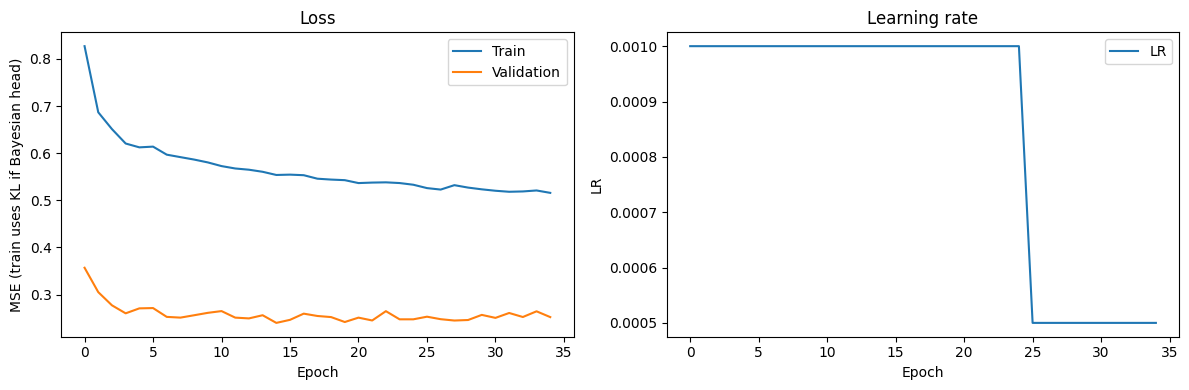

In [12]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history["train_loss"], label="Train")
axes[0].plot(history["val_loss"], label="Validation")
axes[0].set_title("Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("MSE (train uses KL if Bayesian head)")
axes[0].legend()

axes[1].plot(history["lr"], label="LR")
axes[1].set_title("Learning rate")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("LR")
axes[1].legend()

plt.tight_layout()
plt.show()


## 5. Evaluation & Visualization

In [13]:
# Load best model
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.to(device)

from src.vif.eval import evaluate_with_uncertainty, format_results_table

print("Evaluating on test set with MC sampling...")
results = evaluate_with_uncertainty(model, test_loader, n_mc_samples=n_mc_samples, device=device)

print("\n" + format_results_table(results))


Evaluating on test set with MC sampling...

Dimension                   MSE   Spearman   Accuracy
----------------------------------------------------------------------
self_direction           0.3486      0.383     59.02%
stimulation              0.1004      0.482     90.16%
hedonism                 0.2657      0.322     73.77%
achievement              0.2642      0.446     68.85%
power                    0.0984      0.313     90.16%
security                 0.2284      0.412     71.31%
conformity               0.2556      0.289     73.77%
tradition                0.1956      0.584     77.05%
benevolence              0.3951      0.209     60.66%
universalism             0.0696      0.148     95.90%
----------------------------------------------------------------------
MEAN                     0.2222      0.359     76.07%

Calibration:
  Error-uncertainty correlation: -0.285
  Mean uncertainty: 0.1130


In [14]:
# Optional: quick calibration sanity check
# If well-calibrated, higher uncertainty should correlate with higher absolute error.
import numpy as np
from scipy import stats

pred = results["predictions"]
unc = results["uncertainties"]
tgt = results["targets"]

errors = np.abs(pred - tgt)
correlation = stats.spearmanr(unc.flatten(), errors.flatten())[0]

print(f"Error-uncertainty Spearman correlation: {correlation:.3f}")
print(f"Mean uncertainty: {unc.mean():.4f}")


Error-uncertainty Spearman correlation: -0.285
Mean uncertainty: 0.1130


## 6. Ablation Studies (optional)

Try swapping:
- `tcn_num_channels` (depth/width)
- `tcn_kernel_size`
- `tcn_dilations`
- `tcn_use_norm` and `tcn_use_skip_connections`
- `USE_BAYESIAN_HEAD` (Bayesian vs MC Dropout)

In [15]:
# Quick ablation template (rerun model+train cells after changing params)
# Example:
# tcn_num_channels = [128, 128, 128]
# tcn_kernel_size = 5
# tcn_use_skip_connections = True
# USE_BAYESIAN_HEAD = False

print("Edit params in Section 3, then re-run from model instantiation onward.")


Edit params in Section 3, then re-run from model instantiation onward.


In [16]:
# Summary
print("\n" + "=" * 60)
print("TCN CRITIC SUMMARY")
print("=" * 60)
print(f"USE_BAYESIAN_HEAD: {USE_BAYESIAN_HEAD}")
print(f"window_size: {window_size}")
print(f"encoder: {text_encoder.model_name} (dim={text_encoder.embedding_dim})")
print(f"tcn_num_channels: {tcn_num_channels}")
print(f"tcn_kernel_size: {tcn_kernel_size}")
print(f"tcn_dilations: {tcn_dilations}")
print(f"tcn_dropout: {tcn_dropout}")
print(f"head_hidden_dim: {head_hidden_dim}")
print(f"head_dropout: {head_dropout}")
print(f"checkpoint_path: {checkpoint_path}")
print()
print(f"Best val loss: {best_val_loss:.4f}")
print(f"Test MSE mean: {results['mse_mean']:.4f}")
print(f"Test Spearman mean: {results['spearman_mean']:.4f}")
print(f"Test Accuracy mean: {results['accuracy_mean']:.2%}")



TCN CRITIC SUMMARY
USE_BAYESIAN_HEAD: True
window_size: 3
encoder: all-MiniLM-L6-v2 (dim=384)
tcn_num_channels: [64, 64, 64]
tcn_kernel_size: 3
tcn_dilations: None
tcn_dropout: 0.1
head_hidden_dim: 128
head_dropout: 0.2
checkpoint_path: models/vif/notebook_tcn_bayes_best.pt

Best val loss: 0.2399
Test MSE mean: 0.2222
Test Spearman mean: 0.3588
Test Accuracy mean: 76.07%
